In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Loading the spatial tessellation
Taking the shapefile of the 155 [urban areas](https://it.wikipedia.org/wiki/Zone_urbanistiche_di_Roma).

In [15]:
URL_TO_DATA = 'https://drive.google.com/open?id=0B61k9xip8kT3Qk1MbzBGQUNaT1E'.replace('/open?', '/uc?')

gdf_rome = gpd.read_file(URL_TO_DATA)
print(gdf_rome.shape)
print(gdf_rome.crs)
gdf_rome.head()

(155, 8)
epsg:32633


,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946..."
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949..."
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954..."
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932..."
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927..."


In [11]:
# CODZU is a unique ID of each urban area
len(gdf_rome.CODZU)

# note: the total area ('SUPERFICIE') is in hectares (1 hectare = 0.01 km^2)

155

## Covariates

### Point-features
These are features like:
- traffic lights
- POIs

from which we will compute a measure of density for each of the urban areas.

#### Traffic lights

In [50]:
URL_TO_DATA = 'https://www.comune.roma.it/TERRITORIO/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=dit:Semafori&SRSNAME=EPSG:6708&outputFormat=SHAPE-ZIP'

gdf_tl = gpd.read_file(URL_TO_DATA)
print(gdf_tl.shape)
print(gdf_tl.crs)
gdf_tl.head()

(1541, 9)
epsg:6708


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (294246.969 4642743.354)
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (293526.621 4642757.220)
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (295076.397 4642760.961)
3,17058,APL,Via Cipro,None,P.le degli Eroi,Ospedale Oftalmico,I,None,POINT (288360.167 4642762.393)
4,17025,V,Viale Giulio Cesare,None,Via Candia,Via Leone IV,I,Sigma Plus,POINT (288962.732 4642769.784)


In [51]:
# reprojecting onto epsg:32633
gdf_tl_proj = gdf_tl.to_crs(gdf_rome.crs)

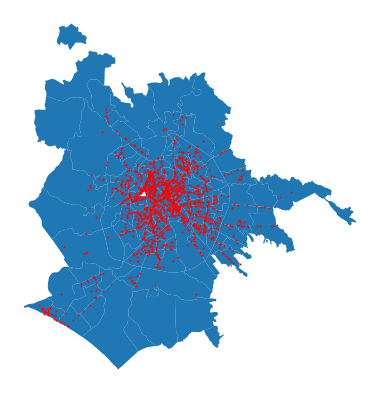

In [52]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_tl_proj.plot(ax=ax, color='red', markersize=0.8)
ax.set_axis_off()

In [54]:
gdf_tl_join = gpd.sjoin(gdf_tl_proj, gdf_rome, how="inner", op='intersects')
print(gdf_tl_join.shape)
gdf_tl_join.head()

(1544, 17)


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry,index_right,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (294246.969 4642743.354),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (293526.621 4642757.220),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (295076.397 4642760.961),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
74,03004,V,Via Nomentana,None,Viale Pola,Via Bosio,II,Omnia,POINT (293761.139 4643576.052),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
82,03064,CL,Circonvallazione Nomentana,328,Via Salento,Tang. Est direzione Foro Italico,II,None,POINT (294914.017 4643637.399),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0


In [60]:
tl_number = gdf_tl_join['CODZU'].value_counts().reset_index()
tl_number.columns = ['CODZU', 'n_traffic_lights']

gdf_rome = gdf_rome.merge(tl_number, how='left', on='CODZU')
print(gdf_rome.shape)
gdf_rome.head()

(155, 9)


,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,n_traffic_lights
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946...",28.0
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949...",25.0
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954...",3.0
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932...",13.0
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927...",5.0


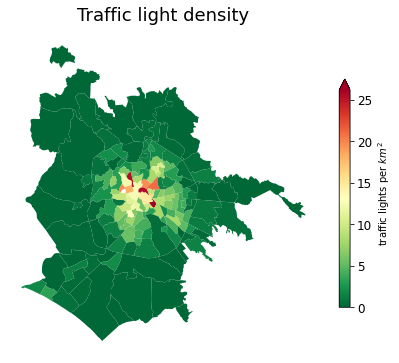

In [98]:
# NaNs are areas where there are zero traffic lights
gdf_rome['n_traffic_lights'] = gdf_rome['n_traffic_lights'].fillna(0)

# compute traffic light density for each area:
gdf_rome['density_traffic_lights'] = gdf_rome['n_traffic_lights'] / (gdf_rome['SUPERFICIE']*0.01)

fig, ax = plt.subplots(1, figsize=(7,7))
gdf_rome.plot(ax=ax, column='density_traffic_lights', cmap='RdYlGn_r', 
              legend=True, legend_kwds={'label': r"traffic lights per $km^2$", 
                                        'orientation': "vertical", 
                                        'shrink':0.6, 'extend':'max'})
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=12)

ax.set_title('Traffic light density', fontsize=18, pad=10)
ax.set_axis_off()

#### Shops

The original .csv can be found at https://dati.comune.roma.it/catalog/dataset/d148/resource/da49d933-c541-4466-920e-2cc24aec0258.

We identified, when possible, the location of each shop from its address, and added it to the .csv as two new columns _lat, lng_. Here we load and use this last new file.

In [7]:
URL_TO_DATA = 'https://www.dropbox.com/s/8yyv0idtca3t8cj/rome_shops_with_location.csv?dl=1'

df_sh = pd.read_csv(URL_TO_DATA)
print(df_sh.shape)
df_sh.head()

(130244, 18)


,NUMEROESERCIZIO,DATAINIZIO,CODICEVIA,DESCRIZIONEVIA,CIVICO,ESPCIVICO,MUNICIPIO,SUPERFICIETOTALE,CODICEMACROATTIVITA,DESCRIZIONEMACROATTIVITA,TIPOATTIVITA,DESCRIZIONEATTIVITA,CODICESPECIALIZZAZIONE,DESCRIZIONESPECIALIZZAZIONE,SUPERFICIEALIMENTARE,SUPERFICIENONALIMENTARE,lat,lng
0,957,20020328,31130.0,VIA DEI CORONARI,37.0,NaN,MUN. I,45,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,36.0,"MOBILI, CASALINGHI E ARTICOLI DI ILLUMINAZIONE",NaN,NON_ALIMENTARE,41.900459,12.470566
1,956,20020314,16160.0,VIA DEL BOSCHETTO,46.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,21.0,"ARTICOLI DI SECONDA MANO (LIBRI, MOBILI, INDUM...",NaN,NON_ALIMENTARE,41.897572,12.490340
2,959,20020228,99862.0,VIA DELLA VII COORTE,5.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,3.0,"BEVANDE (VINI, OLI BIRRA E ALTRE)",ALIMENTARE,NaN,41.888709,12.474520
3,961,20020409,56364.0,VIA GIUSEPPE ROMITA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,27.0,DISTRIBUTORI DI CARBURANTI,NaN,NON_ALIMENTARE,41.903308,12.496302
4,962,20020415,14311.0,VIA BELSIANA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,100,Esercizio di Vicinato,36.0,"MOBILI, CASALINGHI E ARTICOLI DI ILLUMINAZIONE",NaN,NON_ALIMENTARE,41.905523,12.479411


In [26]:
# dropping one row with a completely wrong location (lng = -75.592625)
df_sh.drop(79789, axis=0, inplace=True)

In [14]:
n_shops_no_loc = len(df_sh[(df_sh.lat.isnull()==True) & (df_sh.lng.isnull()==True)])

print('There are %s shops with no identified location (%.1f%%).' %(n_shops_no_loc, n_shops_no_loc/len(df_sh)*100))

There are 801 shops with no identified location (0.6%).


In [27]:
# creating the gdf
gdf_sh = gpd.GeoDataFrame(df_sh, geometry=gpd.points_from_xy(df_sh.lng, df_sh.lat), crs='epsg:4326')

# reprojecting onto epsg:32633
gdf_sh_proj = gdf_sh.to_crs(gdf_rome.crs)

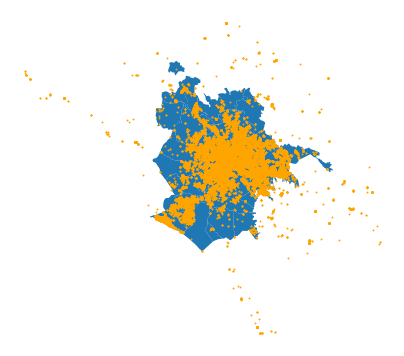

In [30]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_sh_proj.plot(ax=ax, color='orange', markersize=0.8)
ax.set_axis_off()

In [31]:
# taking only the shops inside Rome
gdf_sh_join = gpd.sjoin(gdf_sh_proj, gdf_rome, how="inner", op='intersects')
print(gdf_sh_join.shape)
gdf_sh_join.head()

(127524, 27)


,NUMEROESERCIZIO,DATAINIZIO,CODICEVIA,DESCRIZIONEVIA,CIVICO,ESPCIVICO,MUNICIPIO_left,SUPERFICIETOTALE,CODICEMACROATTIVITA,DESCRIZIONEMACROATTIVITA,...,lng,geometry,index_right,Name,ZU,CODZU,TIPZU,MUNICIPIO_right,GRA,SUPERFICIE
0,957,20020328,31130.0,VIA DEI CORONARI,37.0,NaN,MUN. I,45,CSF,COMMERCIO IN SEDE FISSA,...,12.470566,POINT (290184.664 4641818.516),76,Centro Storico,Centro Storico,1A,1.0,1.0,1.0,320.0
4,962,20020415,14311.0,VIA BELSIANA,4.0,NaN,MUN. I,NaN,CSF,COMMERCIO IN SEDE FISSA,...,12.479411,POINT (290934.893 4642359.131),76,Centro Storico,Centro Storico,1A,1.0,1.0,1.0,320.0
7,965,20020221,68750.0,VIA MARGUTTA,1.0,B,MUN. I,31,CSF,COMMERCIO IN SEDE FISSA,...,12.478311,POINT (290857.550 4642832.962),76,Centro Storico,Centro Storico,1A,1.0,1.0,1.0,320.0
19,991,20030515,111001.0,VIA DEL VANTAGGIO,41.0,A,MUN. I,24,CSF,COMMERCIO IN SEDE FISSA,...,12.476470,POINT (290700.883 4642701.809),76,Centro Storico,Centro Storico,1A,1.0,1.0,1.0,320.0
20,992,20030411,81319.0,LARGO DEL PALLARO,18.0,NaN,MUN. I,31,CSF,COMMERCIO IN SEDE FISSA,...,12.473853,POINT (290441.245 4641263.966),76,Centro Storico,Centro Storico,1A,1.0,1.0,1.0,320.0


In [32]:
shops_number = gdf_sh_join['CODZU'].value_counts().reset_index()
shops_number.columns = ['CODZU', 'n_shops']

gdf_rome = gdf_rome.merge(shops_number, how='left', on='CODZU')
print(gdf_rome.shape)
gdf_rome.head()

(155, 9)


,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,n_shops
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946...",1121
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949...",2597
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954...",105
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932...",1508
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927...",1158


<AxesSubplot:>

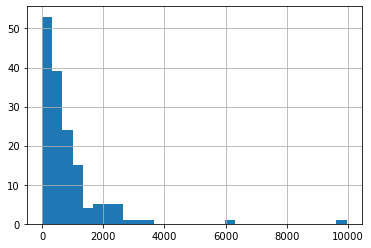

In [34]:
gdf_rome['n_shops'].hist(bins=30)

In [43]:
# there are two areas with very high number of shops

import numpy as np
gdf_rome[gdf_rome['n_shops'] >= np.quantile(gdf_rome['n_shops'], 0.99)]

,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,n_shops,density_shops
76,Centro Storico,Centro Storico,1A,1.0,1.0,1.0,320.0,"POLYGON Z ((290506.355 4642313.420 0.000, 2905...",9955,3110.937500
83,Esquilino,Esquilino,1E,1.0,1.0,1.0,308.0,"POLYGON Z ((292832.320 4641951.105 0.000, 2928...",6166,2001.948052


In [46]:
# NaNs are areas where there are zero shops
gdf_rome['n_shops'] = gdf_rome['n_shops'].fillna(0)

# compute shops density for each area:
gdf_rome['density_shops'] = gdf_rome['n_shops'] / (gdf_rome['SUPERFICIE']*0.01)

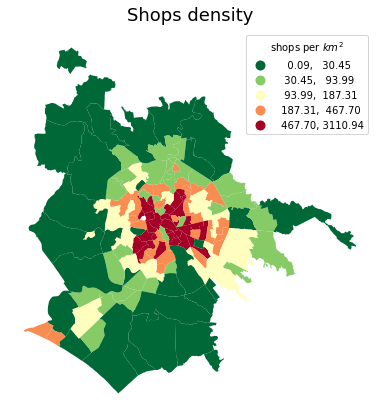

In [59]:
fig, ax = plt.subplots(1, figsize=(7,7))
gdf_rome.plot(ax=ax, column='density_shops', cmap='RdYlGn_r',
              legend=True, legend_kwds={'title': r"shops per $km^2$"}, scheme='quantiles')

ax.set_title('Shops density', fontsize=18, pad=10)
ax.set_axis_off()

### Network features
There features are like
- network density
- edges’ betweenness centrality
- ratio of motorway roads

that can be computed from OpenStreetMap's data.

### Mapparoma's features
These features are the ones we get directly from the [#mapparoma project's open data](https://www.mapparoma.info/open-data/), like
- public transport accessibility
- nmber of car accidents
- population density